In [2]:
import csv
import math
import json
import re
import os
import calendar
import random
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter, defaultdict
from __future__  import division

In [65]:
# Get data line by line from tmdb-5000-movie-database and save the data as dictionary

filepath = "/Users/GretarAtli/Documents/GitHub/Dtu/Dtu-SocialGraphs-FinalProject/Data/tmdb-5000-movie-dataset/tmdb_5000_credits.csv"
tmdb_5000_credits = defaultdict(dict)

with open(filepath) as csvfile:
    reader = csv.DictReader(csvfile, delimiter=",")
    for row in reader:
        tmdb_5000_credits[row["title"]] = row
        tmdb_5000_credits[row["title"]]['cast'] = json.loads(tmdb_5000_credits[row["title"]]['cast'])
        tmdb_5000_credits[row["title"]]['crew'] = json.loads(tmdb_5000_credits[row["title"]]['crew'])

In [66]:
# Get data line by line from tmdb-5000-movie-database and save the data as dictionary

filepath = "/Users/GretarAtli/Documents/GitHub/Dtu/Dtu-SocialGraphs-FinalProject/Data/tmdb-5000-movie-dataset/tmdb_5000_movies.csv"
tmdb_5000_movies = defaultdict(dict)

with open(filepath) as csvfile:
    reader = csv.DictReader(csvfile, delimiter=",")
    for row in reader:
        tmdb_5000_movies[row["title"]] = row
        # put the lists and dictonaries to a correct format, (that is not as string)
        tmdb_5000_movies[row["title"]]['genres'] = json.loads(tmdb_5000_movies[row["title"]]['genres'])
        tmdb_5000_movies[row["title"]]['keywords'] = json.loads(tmdb_5000_movies[row["title"]]['keywords'])
        tmdb_5000_movies[row["title"]]['production_companies'] = json.loads(tmdb_5000_movies[row["title"]]['production_companies'])
        
for title in sorted(tmdb_5000_movies.keys()):
    title = title.replace(" ","-").replace("(","").replace(")","")

In [11]:
# We use the fact that we know that each movie has a name, so we do not include any error handling
def findMovieNameFromId(id):
    name = [key for key,info in tmdb_5000_movies.items() if info['id'] == id]
    return name[0]

In [12]:
result_file_uri = "/Users/GretarAtli/Dropbox/SocialGraph/results/imdb-score-mod-mod.json"

# Getting Imdb scores from data and convert the id to name 

with open(result_file_uri) as json1_file:
#json1_file = open(result_file_uri)
    json1_str = json1_file.read()
    Imdb_5000_movies_withid = json.loads(json1_str)

Imdb_5000_movies = defaultdict(float)

# change the dictionary key from id to name of the movie
for key,value in Imdb_5000_movies_withid.items():
    try: 
        name = findMovieNameFromId(key)
        Imdb_5000_movies[name] = float(value)
    except: 
        print("The movie {} has been removed from kaggle database".format(key))


#  Correlation 

In this section we will investigate the correlation between different variables in our kaggle dataset. To make the analysis a little bit more interesting we added the information about the IMDb rating of each movie. There are some movies that either are missing some values in the kaggle database or they do not have a IMDb rating. We excluded those movies, 6 in total out of 4800 movies. We visualize the findings in a heatmap which shows the correlation coefficients between each pair of variables.

In [94]:
import seaborn as sns; sns.set()

# Get data for each movie 

correlation_data = {
    "1 tmdb_rating" :[],
    "2 imdb_rating" : [],
    "3 popularity" : [],
    "4 budget" : [],
    "5 revenue" : [],
    "6 duration" : [],
    "7 title_year": [],
    "8 id" : [],
    "9 nr_of_actors": []
}

# There are three movies in the database that do not have any imdb ratings, therefore we excluded 
# those movies from the analysis
for movie, imdb_rating in [(key,value) for key,value in Imdb_5000_movies.items() if value != 0 ]:
    
    # There are some movies that either did not have imdb rating or had some information missing from the kaggle database.
    # We handle these cases just by ignoring them. That is the reason for the try and catch loop 
    try:
        tmdb_rating = float(tmdb_5000_movies[movie]['vote_average'])
        imdb_rating = float(imdb_rating)
        popularity = float(tmdb_5000_movies[movie]['popularity'])
        budget = float(tmdb_5000_movies[movie]["budget"])
        revenue = float(tmdb_5000_movies[movie]['revenue'])
        duration = float(tmdb_5000_movies[movie]['runtime'])
        title_year = float(tmdb_5000_movies[movie]["release_date"].split("-")[0])
        movie_id = float(tmdb_5000_movies[movie]['id'])
        nr_of_actors = float(len(tmdb_5000_credits[movie]['cast']))
        
        correlation_data["1 tmdb_rating"].append(tmdb_rating)
        correlation_data["2 imdb_rating"].append(imdb_rating)
        correlation_data["3 popularity"].append(popularity)
        correlation_data["4 budget"].append(budget)
        correlation_data["5 revenue"].append(revenue)
        correlation_data["6 duration"].append(duration)
        correlation_data["7 title_year"].append(title_year)
        correlation_data["8 id"].append(movie_id)
        correlation_data["9 nr_of_actors"].append(nr_of_actors)
    
    except: 
        print("The movie '{}' is missing some values in the database".format(movie))
    

The movie 'America Is Still the Place' is missing some values in the database
The movie 'To Be Frank, Sinatra at 100' is missing some values in the database
The movie 'Chiamatemi Francesco - Il Papa della gente' is missing some values in the database


In [95]:
# Calculate correlation between each variable
# First create 10x10 numpy matrix

corralation_matrix = np.zeros((9,9))

for i,key1 in enumerate(sorted(correlation_data.keys())):
    for j,key2 in enumerate(sorted(correlation_data.keys())):
        corralation_matrix[i][j] = np.corrcoef(correlation_data[key1],correlation_data[key2])[1][0]


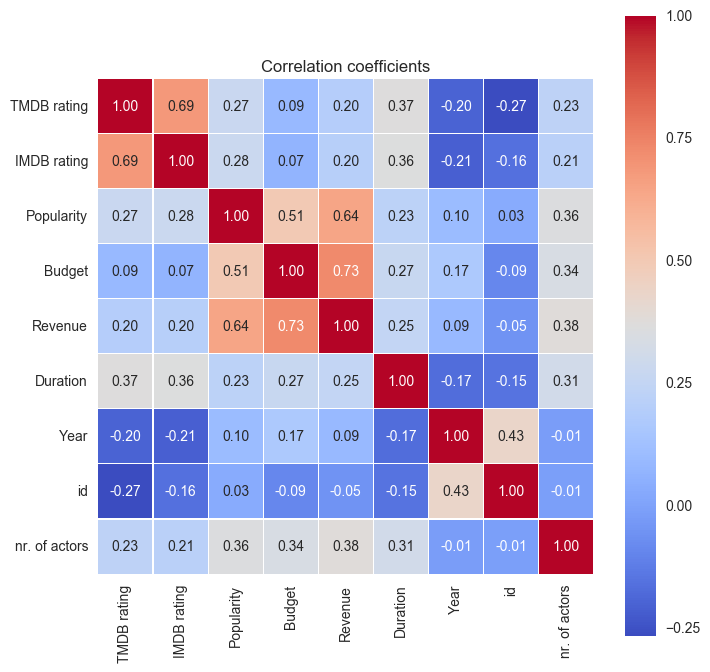

In [101]:
plt.figure(figsize=(8,8))

labels = ["TMDB rating",
         "IMDB rating",
         "Popularity",
         "Budget",
         "Revenue",
         "Duration",
         "Year",
         "id",
         "nr. of actors"]

hm = sns.heatmap(corralation_matrix, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'coolwarm',
                 yticklabels=labels, xticklabels=labels)
plt.title("Correlation coefficients")
plt.show()

** Some thoughts: **

 - The correlation between the TMDb rating and the IMDb rating is interesting, there seems to be less positive correlation between these values than one would expect. This is most likely do to the fact that the TMDb rating is based on much less data, fewer votes on average, than the IMDb rating. Based on these informations we decided to only use the IMDb ratings in further analysis of the dataset. 
 - Budget and revenue is highly positive correlated which means that if a movie has a high budget then the movie is more likely to get higher revenue in the end. Like everyone knows, you need to spend money to make money.
 -  Popularity is also quite correlated with revenue which is something that one could expect. However you would expect the correlation to be higher than 0.64.
 - Duration is also sligthly positive correlated with number of actors. The movie industry gets bigger and bigger each year and therefore the size of the cast of the "newer movies" is bigger than for the "older movies". Here it needs to be taken into account that we have much fewer movies that can be considered to be old in our database. Therefore the correlation is not as much as you would expect but still there is some positive correlation between these variables.